<a href="https://colab.research.google.com/github/guard1000/NLP_MCC/blob/master/0420_keras_BERT_KorquAD(%ED%95%9C%EA%B5%AD%EC%96%B4Q%26A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall tensorflow
!pip install tensorflow==1.15

Uninstalling tensorflow-2.2.0rc3:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0rc3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0rc3
     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 3.8MB 46.2MB/s 
     |████████████████████████████████| 512kB 54.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=9878a39c3befeab9123a9ffa5269c2081ed750f400b8e4115aaddedf30cd2181
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
  

In [7]:
import tensorflow as tf 
print(tf.__version__)

1.15.0


In [0]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

from keras import backend as K
from keras.layers import Layer

import codecs
from tqdm import tqdm
import shutil
import json

In [9]:
#오늘의 keras-bert import
!pip install keras-bert
!pip install keras-radam

In [0]:
# keras_bert의 모듈들 import

from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [0]:
# SQUAD JSON파일을 PANDAS DATAFRAME으로 만들어주는 함수를 정의

def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [12]:
# KorQUAD 데이터를 PANDAS DATAFRAME 형식으로 로드
train = squad_json_to_dataframe_train("/content/drive/My Drive/data/KorQuAD_v1.0_train.json")

Reading the json file
processing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


shape of the dataframe is (60407, 6)
Done


In [13]:
train

,index,question,context,text,answer_start,c_id
0,6566495-0-0,바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,교향곡,54,0
1,6566495-0-1,바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,1악장,421,0
2,6566495-0-2,바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,베토벤의 교향곡 9번,194,0
3,6566518-0-0,1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,파우스트,15,0
4,6566518-0-1,파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,합창교향곡,354,0
...,...,...,...,...,...,...
60402,6467478-1-1,뉴델리 메탈로 베타락마제가 처음 감염 된 지역은 어디인가?,"유전자의 이름은 인도의 수도 뉴델리의 이름을 따 붙여졌는데, 이는 2009년 용 (...",인도,73,9604
60403,6467478-2-0,균은 유전자를 균에게 전달 할 수있는데 이러한 현상을 나타낸 용어는 무엇인가?,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",유전자 전달,253,9605
60404,6467478-2-1,박테리아가 NDM-1 유전자를 가지고 있을때 발생하는 전파를 분석하기위해 사용된 영...,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",37건,129,9605
60405,6490801-2-0,NDM-1 유전자를 가진 박테리아가 감수성을 보인 폴리믹슨 계열 항생제는?,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",콜리스틴,404,9605


In [0]:
# bert 훈련을 위한 사전 설정

# SEQ_LEN 보다 문장의 길이가 작다면 남은 부분은 0 padding
# SEQ_LEN보다 문장 길이가 길다면 SEQ_LEN을 초과하는 부분은 잘라줌

# BATCH_SIZE는  메모리 초과 같은 문제를 방지하기 위해 작은 수인 10으로
# 총 훈련 에포크 수는 1
# 학습율(LR;Learning rate)은 3e-5로 작게 설정

SEQ_LEN = 384
BATCH_SIZE = 10
EPOCHS=1
LR=3e-5

pretrained_path ='/content/drive/My Drive/data/bert3'
config_path = '/content/drive/My Drive/data/bert3/bert_config.json'
checkpoint_path = '/content/drive/My Drive/data/bert3/bert_model.ckpt'
vocab_path = '/content/drive/My Drive/data/bert3/vocab.txt'

DATA_COLUMN = "context"
QUESTION_COLUMN = "question"
TEXT = "text"

In [0]:
# token_dict - voacab.txt 단어에 index 추가하는 딕셔너리
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [0]:
# inherit_Tokenizer 클래스 - Tokenizer 클래스를 상속 받아옴
# _tokenize() 함수 재정의
# --원래 클래스를 그대로 사용하면 입력한 문장이 완전 자모분리 되어버림
# --완전자모분리 : 인공지능 -> ㅇ ㅣ ㄴ ㄱ ㅗ ㅇ ㅈ ㄴ ㅡ ㅇ

class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [0]:
tokenizer = inherit_Tokenizer(token_dict)

In [18]:
# tokenizer 확인
# 버트에선 문장 시작에 [CLS],  문장 끝에 [SEP]이 추가됨
tokenizer.tokenize("SKT Infra AI/DT 추진Cell 최고야")

['[CLS]',
 'sk',
 '##t',
 'in',
 '##fra',
 'ai',
 '/',
 'dt',
 '추',
 '##진',
 '##cell',
 '최고',
 '##야',
 '[SEP]']

In [0]:
# token dict의 key 값과 value 값을 바꾼 reverse_token_dict를 정의
reverse_token_dict = {v : k for k, v in token_dict.items()}

In [0]:
question = train['question'][10]
context = train['context'][10]
text = train['text'][10]

In [21]:
print(question) # 질문
print(context)  # 문장
print(text)     # 정답

바그너는 다시 개정된 총보를 얼마를 받고 팔았는가?
한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다. 이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다. 1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다. 이후 1855년에 리스트가 자신의 작품 파우스트 교향곡을 거의 완성하여 그 사실을 바그너에게 알렸고, 바그너는 다시 개정된 총보를 리스트에게 보내고 브라이트코프흐 & 헤르텔 출판사에는 20루이의 금을 받고 팔았다. 또한 그의 작품을 “하나하나의 음표가 시인의 피로 쓰여졌다”며 극찬했던 한스 폰 뷜로가 그것을 피아노 독주용으로 편곡했는데, 리스트는 그것을 약간 변형되었을 뿐이라고 지적했다. 이 서곡의 총보 첫머리에는 파우스트 1부의 내용 중 한 구절을 인용하고 있다.
20루이의 금


In [22]:
print(tokenizer.tokenize(question, context))

['[CLS]', '바', '##그', '##너', '##는', '다시', '개', '##정', '##된', '총', '##보를', '얼', '##마', '##를', '받고', '팔', '##았', '##는', '##가', '?', '[SEP]', '한편', '1840', '##년부터', '바', '##그', '##너', '##와', '알', '##고', '지', '##내', '##던', '리', '##스트', '##가', '잊', '##혀', '##져', '있던', '1', '##악', '##장을', '부', '##활', '##시', '##켜', '1852', '##년에', '바', '##이', '##마', '##르', '##에서', '연', '##주', '##했다', '.', '이', '##것을', '계', '##기로', '바', '##그', '##너', '##도', '이', '작', '##품', '##에', '다시', '관', '##심을', '갖', '##게', '되었고', ',', '그', '해', '9월', '##에는', '총', '##보', '##의', '반', '##환', '##을', '요', '##구', '##하여', '이를', '서', '##곡', '##으로', '간', '##추', '##린', '다음', '수', '##정을', '했', '##고', '브', '##라', '##이트', '##코', '##프', '##흐', '&', '헤', '##르', '##텔', '출', '##판', '##사에', '##서', '출', '##판', '##할', '개', '##정', '##판', '##도', '준', '##비', '##했다', '.', '1853', '##년', '5월', '##에는', '리', '##스트', '##가', '이', '작', '##품', '##이', '수', '##정되었다', '##는', '것을', '인', '##정', '##했지만', ',', '끝', '##내', '바', '##그', '##너', '##의', '출', '##판',

In [26]:
print(tokenizer.tokenize(text))

['[CLS]', '20', '##루', '##이의', '금', '[SEP]']


In [0]:
# 목적: 질문(question)과 문장(context)를 받아서, 정답(text)를 맞추는 모델을 만드는 것
# 정답을 통째로 맞추는 것이 아니라, 토큰화된 것의 맨 앞 단어와, 맨 뒷 단어
# 토큰화된 정답은 ['[CLS]', 'saint', 'bern', '##ade', '##tte', 'sou', '##bir', '##ous', '[SEP]'] 인데,
# 여기서 saint에 해당하는 위치와 ##ous에 해당하는 위치를 맞추는 버트 모형을 파인튜닝

In [0]:
# convert_data 함수 
# 1) 정답(text) 길이만큼 문장(context)를 슬라이딩 하면서
# 2) 만약에 문장이 정답을 포함하는 위치에 도달시
# 3) 문장에서 정답의 맨 앞이 우리가 예측할 1번째 정답, 정답의 맨 뒤가 우리가 예측할 2번째 정답

def convert_data(data_df):
    global tokenizer
    indices, segments, target_start, target_end = [], [], [], []
    for i in tqdm(range(len(data_df))):
        
        ids, segment = tokenizer.encode(data_df[QUESTION_COLUMN][i], data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        
        text = tokenizer.encode(data_df[TEXT][i])[0]

        text_slide_len = len(text[1:-1])
        for i in range(1,len(ids)-text_slide_len-1):  
            exist_flag = 0
            if text[1:-1] == ids[i:i+text_slide_len]:
              ans_start = i
              ans_end = i + text_slide_len - 1
              exist_flag = 1
              break
        
        if exist_flag == 0:
          ans_start = SEQ_LEN
          ans_end = SEQ_LEN

        indices.append(ids)
        segments.append(segment)

        target_start.append(ans_start)
        target_end.append(ans_end)

    indices_x = np.array(indices)
    segments = np.array(segments)
    target_start = np.array(target_start)
    target_end = np.array(target_end)
    
    del_list = np.where(target_start!=SEQ_LEN)[0]

    indices_x = indices_x[del_list]
    segments = segments[del_list]
    target_start = target_start[del_list]
    target_end = target_end[del_list]

    train_y_0 = keras.utils.to_categorical(target_start, num_classes=SEQ_LEN, dtype='int64')
    train_y_1 = keras.utils.to_categorical(target_end, num_classes=SEQ_LEN, dtype='int64')
    train_y_cat = [train_y_0, train_y_1]
    
    return [indices_x, segments], train_y_cat


def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[QUESTION_COLUMN] = data_df[QUESTION_COLUMN].astype(str)


    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [24]:
train_x, train_y = load_data(train)

100%|██████████| 60407/60407 [01:27<00:00, 692.90it/s]


In [25]:
train_x[0]

array([[   101,   9318,  78136, ...,  12178,   9011,    102],
       [   101,   9318,  78136, ...,   9011, 118783,    102],
       [   101,   9318,  78136, ...,   9011, 118783,    102],
       ...,
       [   101,   9319, 119351, ...,      0,      0,      0],
       [   101,    182,  10162, ...,      0,      0,      0],
       [   101,  19145,  17289, ...,      0,      0,      0]])

In [26]:
train.shape

(60407, 6)

In [27]:
# 데이터 약 10000개 소실
# -- 원인: 길이가 384가 넘는 인풋인 경우에 
# -- context 내에 정답을 포함하고 있는 context가 잘려서 정답을 포함하지 않는 경우가 있음
# -- 이런 애들을 convert_data()에서 del_list로 지정해서 빼줬기 떄문!
train_x[0].shape

(50609, 384)

In [28]:
# pretrained model loading

layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=False,
    trainable=True,
    seq_len=SEQ_LEN,)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
___________

In [0]:
# Transfer learning을 위해 Custom Layer를 작성
# NonMasking 함수를 지정해서, Bert 모형의 자체 Masking 된 텐서들을 풀어줌
# 이 문제에서 만약 NonMasking 클래스를 만들지 않는다면, Bert 모형을 훈련할 수 없음

class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape

In [0]:
# Keras Custom Layer 2개를 생성
# --MyLayer_Start는 정답의 첫 번째 단어를 예측하는 것을 담당
# --MyLaer_End는 정답의 마지막 단어를 예측하는 것을 담당

# 사실 두 레이어는 동일한 역할을 수행
# --Bert 모형의 마지막 입력을 받아서, (batch_size, 384, 768)의 텐서 모양을 (batch_size, 384, 2)로 만들어주는 텐서를 곱해줌
# --이후 i) (batch_size, 384), ii) (batch_size, 384)의 아웃풋을 출력할 수 있게 하나의 텐서를 두개로 잘라줌

# 왜 끝이 384냐면, 384개의 위치를 예측하기 때문 -> 단어의 위치의 최대 개수는 384개로 앞서 지정했음(SEQ_LEN)

class MyLayer_Start(Layer):

    def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_Start, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[2],2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_Start, self).build(input_shape)

    def call(self, x):
        
        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        x = K.dot(x, self.W)
        
        x = K.permute_dimensions(x, (2,0,1))

        self.start_logits, self.end_logits = x[0], x[1]
        
        self.start_logits = K.softmax(self.start_logits, axis=-1)
        
        return self.start_logits

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)


class MyLayer_End(Layer):
  def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_End, self).__init__(**kwargs)
  
  def build(self, input_shape):
        
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[2], 2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_End, self).build(input_shape)

  
  def call(self, x):

        
        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        x = K.dot(x, self.W)
        x = K.permute_dimensions(x, (2,0,1))
        
        self.start_logits, self.end_logits = x[0], x[1]
        
        self.end_logits = K.softmax(self.end_logits, axis=-1)
        
        return self.end_logits

  def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)

In [0]:
# BERT 모델을 출력하는 함수를 지정
# start_answer, end_answer를 예측하게 됨

from keras.layers import merge, dot, concatenate
from keras import metrics
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.output
  x = NonMasking()(dense)
  outputs_start = MyLayer_Start(SEQ_LEN)(x)
  outputs_end = MyLayer_End(SEQ_LEN)(x)
  bert_model = keras.models.Model(inputs, [outputs_start, outputs_end])
  bert_model.compile(
      optimizer=RAdam(learning_rate=LR, decay=0.0001),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

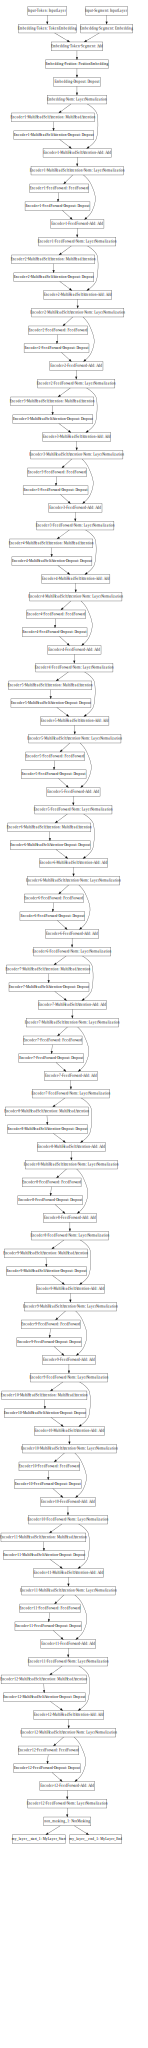

In [32]:
# 모델의 FLOW 확인

from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

In [38]:
# 훈련시작
# 1epoch을 훈련하고 결과를 확인한 후 훈련을 다시 시작할 예정

sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
bert_model.summary()
history = bert_model.fit(train_x, train_y, batch_size=10, validation_split=0.05, shuffle=False, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]             

In [34]:
bert_model = get_bert_finetuning_model(model)
bert_model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
# BERT MODEL을 저장
bert_model.save_weights("/content/drive/My Drive/data/bert3/squad_wordpiece.h5")


In [35]:
# 버트 모형을 다시 훈련
# 이번에는 validation_split을 입력하지 않아서 전체 데이터가 훈련 되도록 만들어 줌

bert_model.compile(optimizer=RAdam(learning_rate=0.00003, decay=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
bert_model.fit(train_x, train_y, batch_size=10, shuffle=False, verbose=1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1
50609/50609 [==============================] - 5388s 106ms/step - loss: 0.9474 - my_layer__start_3_loss: 0.4376 - my_layer__end_3_loss: 0.5098 - my_layer__start_3_accuracy: 0.8795 - my_layer__end_3_accuracy: 0.8621


In [0]:
# BERT MODEL을 저장2
bert_model.save_weights("/content/drive/My Drive/data/bert3/squad_wordpiece2.h5")


In [0]:
# 버트 모형을 한번 더 훈련 
# 이번에는 learning_rate을 0.00001로 바꿔 줌

bert_model.compile(optimizer=RAdam(learning_rate=0.00001, decay=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# BERT MODEL을 저장3
bert_model.save_weights("/content/drive/My Drive/data/bert3/squad_wordpiece3.h5")


In [0]:
# 버트 모형을 로드하고, 이미 로드하였던 모델에 계수들만 살짝 얹혀 주자

bert_model = get_bert_finetuning_model(model)
bert_model.load_weights("/content/drive/My Drive/data/bert3/squad_wordpiece3.h5")


In [0]:
# Test data set에 대한 bert_input을 만들어 줌
# Train data set과는 다르게 label을 생성하지 않아도 된다.

def convert_pred_data(question, doc):
    global tokenizer
    indices, segments = [], []
    ids, segment = tokenizer.encode(question, doc, max_len=SEQ_LEN)
    indices.append(ids)
    segments.append(segment)
    indices_x = np.array(indices)
    segments = np.array(segments)
    return [indices_x, segments]

def load_pred_data(question, doc):
    data_x = convert_pred_data(question, doc)
    return data_x

In [0]:
# 질문과 문장을 받아 답을 알려주는 함수를 정의

def predict_letter(question, doc):
  
  test_input = load_pred_data(question, doc)
  test_start, test_end = bert_model.predict(test_input)
  
  indexes = tokenizer.encode(question, doc, max_len=SEQ_LEN)[0]
  start = np.argmax(test_start, axis=1).item()
  end = np.argmax(test_end, axis=1).item()
  start_tok = indexes[start]
  end_tok = indexes[end]
  print("Question : ", question)
  
  print("-"*50)
  print("Context : ", end = " ")
  
  def split_text(text, n):
    for line in text.splitlines():
        while len(line) > n:
           x, line = line[:n], line[n:]
           yield x
        yield line

  
  for line in split_text(doc, 150):
    print(line)

  print("-"*50)
  print("ANSWER : ", end = " ")
  print("\n")
  sentences = []
  
  for i in range(start, end+1):
    token_based_word = reverse_token_dict[indexes[i]]
    sentences.append(token_based_word)
    print(token_based_word, end= " ")
  
  print("\n")
  print("Untokenized Answer : ", end = "")
  for w in sentences:
    if w.startswith("##"):
      w = w.replace("##", "")
    else:
      w = " " + w
    
    print(w, end="")
  print("")

In [0]:
# dev 파일을 PANDAS DATAFRAME 형식으로 불러오는 함수를 정의
# train 데이터와 모양이 약간 다르기 때문에, 함수를 새로 정의해야 함

def squad_json_to_dataframe_dev(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [43]:
# test용 dev 파일 pandas로 불러오기

input_file_path = "/content/drive/My Drive/data/KorQuAD_v1.0_dev.json"
record_path = ['data','paragraphs','qas','answers']
verbose = 0
dev = squad_json_to_dataframe_dev(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...
shape of the dataframe is (5774, 5)
Done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [44]:
# TEST Data 확인
dev

,id,question,context,answers,c_id
0,6548850-0-0,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '1989년 2월 15일', 'answer_start': 0}]",0
1,6548850-0-1,1989년 6월 30일 평양축전에 대표로 파견 된 인물은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '임수경', 'answer_start': 125}]",0
2,6548853-0-0,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '1989년', 'answer_start': 0}]",0
3,6548853-0-1,임종석을 검거한 장소는 경희대 내 어디인가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '학생회관 건물 계단', 'answer_start': 365}]",0
4,6548853-0-2,임종석이 조사를 받은 뒤 인계된 곳은 어딘가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '서울지방경찰청 공안분실', 'answer_start': 457}]",0
...,...,...,...,...,...
5769,6511152-4-0,중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생한 년도는?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '2016년', 'answer_start': 0}]",959
5770,6511152-4-1,갤럭시 S7엣지를 만든 회사는?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '삼성전자', 'answer_start': 83}]",959
5771,6511152-4-2,2016년 9월 4일 갤럭시 S7엣지가 폭발한 사건이 발생한 지역은?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '중동 지역', 'answer_start': 12}]",959
5772,6535617-4-0,갤럭시 노트 7은 출시 며칠만에 기기 결함으로 터지기 시작하였나?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '18일', 'answer_start': 286}]",959


In [84]:
# TEST DATA에 대한 결과 확인

import random
for i in random.sample(range(10),10):
  doc = dev['context'][i]
  question = dev['question'][i]
  answers = dev['answers'][i]
  predict_letter(question, doc)
  print("")
  print("real answer : ", answers)
  print("")

Question :  정부의 헌법개정안 준비 과정에 대해서 청와대 비서실이 아니라 국무회의 중심으로 이뤄졌어야 했다고 지적한 원로 헌법학자는?
--------------------------------------------------
Context :  "내각과 장관들이 소외되고 대통령비서실의 권한이 너무 크다", "행보가 비서 본연의 역할을 벗어난다"는 의견이 제기되었다. 대표적인 예가 10차 개헌안 발표이다. 원로 헌법학자인 허영 경희대 석좌교수는 정부의 헌법개정안 준비 과정에 대해 "청와대 비서실이 아닌 국무회의
 중심으로 이뤄졌어야 했다"고 지적했다. '국무회의의 심의를 거쳐야 한다'(제89조)는 헌법 규정에 충실하지 않았다는 것이다. 그러면서 "법무부 장관을 제쳐놓고 민정수석이 개정안을 설명하는 게 이해가 안 된다"고 지적했다. 민정수석은 국회의원에 대해 책임지는 법무부 장
관도 아니고, 국민에 대해 책임지는 사람도 아니기 때문에 정당성이 없고, 단지 대통령의 신임이 있을 뿐이라는 것이다. 또한 국무총리 선출 방식에 대한 기자의 질문에 "문 대통령도 취임 전에 국무총리에게 실질적 권한을 주겠다고 했지만 그러지 못하고 있다. 대통령비서실장만
도 못한 권한을 행사하고 있다."고 답변했다.
--------------------------------------------------
ANSWER :  

허 ##영 

Untokenized Answer :  허영

real answer :  [{'text': '허영', 'answer_start': 100}]

Question :  '행보가 비서 본연의 역할을 벗어난다', '장관들과 내각이 소외되고 대통령비서실의 권한이 너무 크다'는 의견이 제기된 대표적인 예는?
--------------------------------------------------
Context :  "내각과 장관들이 소외되고 대통령비서실의 권한이 너무 크다", "행보가 비서 본연의 역할을 벗어난다"는 의견이 제기되었다. 대표적인 예가 10

In [46]:
# 모형에 질문해보기

doc = "태양계의 5번째 행성이며, 태양계의 행성 중 가장 부피가 크고 무겁다. 반지름은 지구의 11.2배, 부피는 지구의 1300배가 넘는다. 질량은 지구의 318배다. 부피에 비해 질량이 작은 이유는 암석형 행성보다 밀도가 낮은 성분들이 주요 구성성분인 가스형 행성이기 때문이다. 그럼에도 목성의 질량은 다른 태양계 행성들을 합친 것보다도 무겁다. 심지어 그 7개 행성의 질량을 몽땅 다 합쳐도 목성의 절반도 되지 않는다. 태양계에서 태양이 99.86%를 차지하고, 목성은 나머지 0.14% 중에서 약 2/3인 0.095%를 차지한다. 뒤를 이어 토성이 0.029%를 차지하며, 나머지 행성들을 모두 합쳐도 태양계 질량의 0.016% 정도 밖에 되지 않는다."
question = "목성의 부피는 지구의 몇배인가?"

predict_letter(question, doc)


Question :  목성의 부피는 지구의 몇배인가?
--------------------------------------------------
Context :  태양계의 5번째 행성이며, 태양계의 행성 중 가장 부피가 크고 무겁다. 반지름은 지구의 11.2배, 부피는 지구의 1300배가 넘는다. 질량은 지구의 318배다. 부피에 비해 질량이 작은 이유는 암석형 행성보다 밀도가 낮은 성분들이 주요 구성성분인 가스형 행성이기 때문
이다. 그럼에도 목성의 질량은 다른 태양계 행성들을 합친 것보다도 무겁다. 심지어 그 7개 행성의 질량을 몽땅 다 합쳐도 목성의 절반도 되지 않는다. 태양계에서 태양이 99.86%를 차지하고, 목성은 나머지 0.14% 중에서 약 2/3인 0.095%를 차지한다. 뒤를 
이어 토성이 0.029%를 차지하며, 나머지 행성들을 모두 합쳐도 태양계 질량의 0.016% 정도 밖에 되지 않는다.
--------------------------------------------------
ANSWER :  

1300 ##배 

Untokenized Answer :  1300배


In [54]:
# 모형에 질문해보기 2
doc = "사스와 메르스처럼 코로나 바이러스의 보고되지 않은 종에 인한 감염으로 발생하는 호흡기 질환이다. 최초 발생 원인과 전파 경로는 아직 정확히 밝혀지지 않았다.발병 초기에 보고된 불상의 폐병 증상으로 대중적으로는 '우한 폐렴' 등의 키워드로 불렸으며, 현재 세계보건기구(WHO)에서는 Novel coronavirus(2019-nCoV)라는 표현을 사용 중이다(#). 미국, 영국 등 일부 외신에서는 Wuhan coronavirus라는 표현을 사용하기도 한다. 현재 미국 정부는 질병 명칭에는 Wuhan을 넣지 않은 Coronavirus라고만 지칭 중이다.[11] 대한민국 정부에서 잠정적으로 사용하는 질병 명칭은 신종 코로나바이러스감염증이다. 이는 2015년부터 낙인 효과를 우려한 WHO에서 병명에 지역 이름을 넣는 것을 피하도록 한 권고[12](#)에 따른 것이다. 물론 해당 권고는 구속력이 없으며, 정부나 공공 의료기관이 아닌 일반인, 그리고 언론이 우한 폐렴을 사용하는 것에도 문제가 없다. 실제로 외신이나 당사자인 중국 본토에서도 '우한' 혹은 '중국' 명칭을 사용하고 있다. #기사 사태 초반에는 우한시 안에 국한될 것으로 판단하는 이들이 많았으나, 점차 우한 외 후베이성과 인근 지역, 그리고 중국을 벗어나 해외로까지 퍼지면서 상황이 심각해졌다. 우한시의 인구는 약 1,100만 명이며, 하필 맞물린 춘절[13]로 인한 인구 대이동으로 병이 사방으로 퍼질 위험이 있어 중국 현지에 비상이 걸렸다. 게다가 춘절 기간 중 중국인 관광객들이 해외여행을 많이 가다보니 세계 여러 나라에서도 촉각이 곤두서있다. 따라서 춘절 전후가 감염병 확산의 고비라 할 수 있다."
question = "주제는?"

predict_letter(question, doc)


Question :  주제는?
--------------------------------------------------
Context :  사스와 메르스처럼 코로나 바이러스의 보고되지 않은 종에 인한 감염으로 발생하는 호흡기 질환이다. 최초 발생 원인과 전파 경로는 아직 정확히 밝혀지지 않았다.발병 초기에 보고된 불상의 폐병 증상으로 대중적으로는 '우한 폐렴' 등의 키워드로 불렸으며, 현재 세계보건기구(W
HO)에서는 Novel coronavirus(2019-nCoV)라는 표현을 사용 중이다(#). 미국, 영국 등 일부 외신에서는 Wuhan coronavirus라는 표현을 사용하기도 한다. 현재 미국 정부는 질병 명칭에는 Wuhan을 넣지 않은 Coronavirus라고만
 지칭 중이다.[11] 대한민국 정부에서 잠정적으로 사용하는 질병 명칭은 신종 코로나바이러스감염증이다. 이는 2015년부터 낙인 효과를 우려한 WHO에서 병명에 지역 이름을 넣는 것을 피하도록 한 권고[12](#)에 따른 것이다. 물론 해당 권고는 구속력이 없으며, 정
부나 공공 의료기관이 아닌 일반인, 그리고 언론이 우한 폐렴을 사용하는 것에도 문제가 없다. 실제로 외신이나 당사자인 중국 본토에서도 '우한' 혹은 '중국' 명칭을 사용하고 있다. #기사 사태 초반에는 우한시 안에 국한될 것으로 판단하는 이들이 많았으나, 점차 우한 외
 후베이성과 인근 지역, 그리고 중국을 벗어나 해외로까지 퍼지면서 상황이 심각해졌다. 우한시의 인구는 약 1,100만 명이며, 하필 맞물린 춘절[13]로 인한 인구 대이동으로 병이 사방으로 퍼질 위험이 있어 중국 현지에 비상이 걸렸다. 게다가 춘절 기간 중 중국인 관광
객들이 해외여행을 많이 가다보니 세계 여러 나라에서도 촉각이 곤두서있다. 따라서 춘절 전후가 감염병 확산의 고비라 할 수 있다.
--------------------------------------------------
ANSWER :  

신 ##종 코 ##로 ##나 ##바 ##이 ##러 ##스

In [55]:
################### 뉴스 기사로 해보기 ###########################################

news_IT = pd.read_csv("/content/drive/My Drive/data/0418/Article_IT과학.csv")
news_IT.rename(columns={'이데일리 김현아 기자 여기어때의 이메일 유출 관련 공지 출처 여기어때 홈페이지 . 현재 다른 회원 수신자수는 9 19명으로 수정돼 있다. 호텔·모텔 등 숙박앱 ‘여기어때’를 운영하는 위드이노베이션 대표 황재웅 이 관련 법에 따라 개인정보 이용내역을 통지하는 과정에서 회원들의 이메일 주소가 유출되는 사고가 발생했다. 1일 위드이노베이션에 따르면 어제 지난달 31일 회원들에게 개인정보 이용내역을 통지하기 위해 안내 이메일을 발신하던 중 수신인 설정 오류로 다수 회원의 이메일 주소가 유출됐다. 본인 외에 다른 회원 9 19명 이메일 주소가 함께 포함돼 발송된 것이다. 위드이노베이션 관계자는 “유출된 항목은 이메일 주소 1개이며 사실을 확인한 즉시 한국인터넷진흥원에 신고했다”며 “혹시 다른 수신인들의 이메일을 아셨더라도 불법 이용을 금지해달라”고 밝혔다. 이어 “수신인들의 그룹별 명단을 확보했고 메일 일괄 발송시 확인절차를 강화했다”며 “혹시 이번 사건으로 의심 메일을 받는 등 피해가 의심된다면 담당부서로 신고해 달라”고 부연했다.' : 'document', '20190101': '일자'}, inplace=True)
news_IT= news_IT[['일자','document']]
news_IT.head()
news_IT.tail()

,일자,document
11395,20190118,메가박스 월드컵경기장점 2층 이데일리 김혜미 기자 엔씨소프트 036570 가 멀티플...
11396,20190118,이데일리 김현아 기자 미디어연대 공동대표 이석우 조맹기 황우섭 가 바른사회시민회의와...
11397,20190118,질문 키워드·채택왕·추천Q A 등 확인 가능 이데일리 한광범 기자 네이버는 지식 공...
11398,20190118,동방사회복지회에 기부금 전달…입양대기 아동 봉사활동 진행 아이뉴스24 김나리 기자 ...
11399,20190118,서울 여의도 LG 트윈타워에서 모델이 LG Q9을 소개하고 있다. LG전자 제공 2...


In [56]:
it_1_18 = news_IT[news_IT['일자'] == 20190118]
it_1_18 = list(it_1_18['document'])
len(it_1_18)

303

In [63]:
# ~~ 일보 ~~ 기자 로 시작하는 부분 제거
for i in range(len(it_1_18)):
  if '기자' in it_1_18[i].split()[:4]:
    pos = it_1_18[i].split().index('기자')
    it_1_18[i] = ' '.join(it_1_18[i].split()[pos+1:])
it_1_18[100]

'블리자드엔터테인먼트는 자사의 액션RPG 디아블로 3 에 신규 16 시즌 을 시작한다. 이번 시즌의 테마는 권위 로 지난 시즌들과는 다르게 플레이 방식을 바꿔줄 최신 강화 효과가 도입된다. 16 시즌 동안 모든 시즌 캐릭터에 왕실 권위의 반지 전설 능력이 적용된다. 왕실 권위의 반지 는 강력한 세트 아이템 효과를 받기 위해 필요한 아이템의 개수를 한 개 감소시켜주는 아이템으로 실제로 많은 플레이스타일의 핵심 아이템 중 하나이다. 플레이어들은 반지를 직접 착용하거나 카나이의 함을 통해 능력을 추출해 사용하곤 하는데 이번 시즌에는 반지를 별도로 획득하지 않아도 전설 효과를 받을 수 있다. 새로운 꾸미기 여정 정벌 등 시즌동안 즐길 수 있는 콘텐츠도 다시 돌아온다. 우선 독점 정복자 세트의 투구와 어깨 부위 모험 테마의 최신 초상화 렘포의 날개 등 새로운 꾸미기 아이템들이 시즌 여정을 통해 획득할 수 있다. 최종봉 기자 konako12 fomos.co.kr 게임 게이머 문화를 전합니다.'

In [66]:
doc = it_1_18[100]
question = "16시즌의 특징은 무엇인가?"

predict_letter(question, doc)

Question :  16시즌의 특징은 무엇인가?
--------------------------------------------------
Context :  블리자드엔터테인먼트는 자사의 액션RPG 디아블로 3 에 신규 16 시즌 을 시작한다. 이번 시즌의 테마는 권위 로 지난 시즌들과는 다르게 플레이 방식을 바꿔줄 최신 강화 효과가 도입된다. 16 시즌 동안 모든 시즌 캐릭터에 왕실 권위의 반지 전설 능력이 적용된다. 왕실
 권위의 반지 는 강력한 세트 아이템 효과를 받기 위해 필요한 아이템의 개수를 한 개 감소시켜주는 아이템으로 실제로 많은 플레이스타일의 핵심 아이템 중 하나이다. 플레이어들은 반지를 직접 착용하거나 카나이의 함을 통해 능력을 추출해 사용하곤 하는데 이번 시즌에는 반지를
 별도로 획득하지 않아도 전설 효과를 받을 수 있다. 새로운 꾸미기 여정 정벌 등 시즌동안 즐길 수 있는 콘텐츠도 다시 돌아온다. 우선 독점 정복자 세트의 투구와 어깨 부위 모험 테마의 최신 초상화 렘포의 날개 등 새로운 꾸미기 아이템들이 시즌 여정을 통해 획득할 수 
있다. 최종봉 기자 konako12 fomos.co.kr 게임 게이머 문화를 전합니다.
--------------------------------------------------
ANSWER :  

권 ##위 

Untokenized Answer :  권위


In [83]:
doc = it_1_18[25]
question1 = "주제가 무엇인가?"
question2 = "이벤트 보상은 무엇을 지급하는가?"

predict_letter(question1, doc)
predict_letter(question2, doc)


Question :  주제가 무엇인가?
--------------------------------------------------
Context :  웹젠 대표 김태영 은 웹게임 ‘뮤템페스트’에 신규 콘텐츠 ‘성물강화’와 ‘병사의혼’을 선보였다. 우선 ‘성물강화’는 캐릭터의 능력치를 높일 수 있는 콘텐츠다. 이용자는 ‘궁니르’ ‘만법의 서’ ‘죽음의 선율’ ‘요괴의 나팔’ ‘판결 천칭’ 등 5가지 새로운 성물을 강화
해 더욱 강한 전투력을 갖춘 캐릭터를 육성할 수 있다. ‘병사의혼’도 캐릭터 능력 향상 콘텐츠다. 여분의 아이템을 사용해 ‘아틀란스’ ‘칸투르’ ‘아르카’ 등의 병사의혼을 활성화하면 각각 ‘방어 무시’ ‘데미지 흡수’ ‘중상 효과’ 등의 속성이 캐릭터 능력치에 부여된다
. 또 ‘도감 정수’를 사용해 원하는 몬스터 혼을 합성할 수 있는 ‘도감 합성’과 효율적인 사냥에 도움을 주는 ‘마스터 더블 스킬’ 등도 도입됐다. 웹젠은 오는 31일까지 접속 이벤트도 연다. 평일 오후 12시 오후 6시에 접속한 이용자에게 귀속 다이아를 지급하는 내용
이다. 또 18일부터 20일 25일부터 27일까지 2차에 걸쳐 ‘다이아 소비 랭킹 이벤트’도 펼쳐진다. 서버별 랭킹 1 3등에게 최대 ‘11급 2옵션 목걸이’ 등이 지급된다.
--------------------------------------------------
ANSWER :  

성 ##물 ##강 ##화 [UNK] 와 [UNK] 병 ##사의 ##혼 

Untokenized Answer :  성물강화 [UNK] 와 [UNK] 병사의혼
Question :  이벤트 보상은 무엇을 지급하는가?
--------------------------------------------------
Context :  웹젠 대표 김태영 은 웹게임 ‘뮤템페스트’에 신규 콘텐츠 ‘성물강화’와 ‘병사의혼’을 선보였다. 우선 ‘성물강화’는 캐릭터의 능력치를 높일 수 있는 콘텐츠다. 이용자는 ‘궁니르’ ‘만법의 서’ ‘죽음의 선율’ ‘요괴의 